# Phase A: Exploration et Analyse des Données

## Objectifs
- Charger les datasets (Business, User, Review)
- Nettoyer et fusionner les données
- Analyser les distributions (Catégories, Notes, etc.)
- Analyser les corrélations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import polars as pl

In [2]:
DATA_DIR = "../Data"
pd.set_option('display.max_columns', None)

# Lecture du JSONL de manière plus rapide avec Polars

# 1. Chargement des Business
print("Chargement du dataset Business...")
business_df = pl.read_ndjson(os.path.join(DATA_DIR, "yelp_academic_dataset_business.json"))
print(f"Business shape: {business_df.shape}")

# 2. Chargement des Users
print("Chargement du dataset User...")
user_df = pl.read_ndjson(os.path.join(DATA_DIR, "yelp_academic_dataset_user4students.jsonl"))
print(f"User shape: {user_df.shape}")

# 3. Chargement des Reviews
print("Chargement du dataset Review...")
review_df = pl.read_ndjson(os.path.join(DATA_DIR, "yelp_academic_reviews4students.jsonl"))
print(f"Review shape: {review_df.shape}")

# Revenir à Pandas :
business_df = business_df.to_pandas()
user_df = user_df.to_pandas()
review_df = review_df.to_pandas()

Chargement du dataset Business...
Business shape: (150346, 14)
Chargement du dataset User...
User shape: (558095, 22)
Chargement du dataset Review...
Review shape: (1000000, 9)


In [11]:
business_df.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"{'BusinessParking': None, 'BusinessAcceptsCred...","Doctors, Traditional Chinese Medicine, Naturop...",None


In [12]:
review_df.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,1522876193000


In [14]:
user_df.head(1)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,65,55,56,18,232,844,467,467,239,180


## 1. Fusion des données

In [3]:
# Fusion Review + Business 
df = review_df.merge(business_df, on="business_id", how="left", suffixes=("_review", "_biz"))

# Fusion + User 
df = df.merge(user_df, on="user_id", how="left", suffixes=("", "_user"))

print(f"Fused dataset shape: {df.shape}")
df.head(1)

Fused dataset shape: (1000000, 43)


,review_id,user_id,business_id,stars_review,useful,funny,cool,text,date,name,address,city,state,postal_code,latitude,longitude,stars_biz,review_count,is_open,attributes,categories,hours,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,1522876193000,Bru Burger Bar - Indianapolis,410 Massachusetts Ave,Indianapolis,IN,46204,39.773307,-86.152091,4.0,1608,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Gluten-Free, Bars, Food, Nightlif...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",Dev,41.0,2017-11-11 05:55:29,24.0,4.0,18.0,2021,"X0BSdbAfXOfi5hzAbPmBKg, 6shiT2w2lQLqbmFEif5xCg...",1.0,3.72,1.0,0.0,0.0,0.0,0.0,7.0,1.0,6.0,6.0,1.0,1.0


### Vérifier si les données se sont bien "accrochées"

In [ ]:
# Vérifier combien d'avis n'ont PAS trouvé leur business ou leur user
missing_biz = df['name'].isna().sum()
missing_user = df['name_user'].isna().sum() 

print(f"Avis orphelins (sans info business) : {missing_biz}")
print(f"Avis orphelins (sans info user) : {missing_user}")

Avis orphelins (sans info business) : 0
Avis orphelins (sans info user) : 4


#### Nettoyage des données orphelines

In [ ]:
# On supprime les lignes qui n'ont pas d'info utilisateur
df = df.dropna(subset=['name_user']) 

print(f"Nouvelle taille après nettoyage : {df.shape}")

## 2. Analyse des catégories de Business

C:\Users\anas\AppData\Local\Temp\ipykernel_1784\2457323310.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


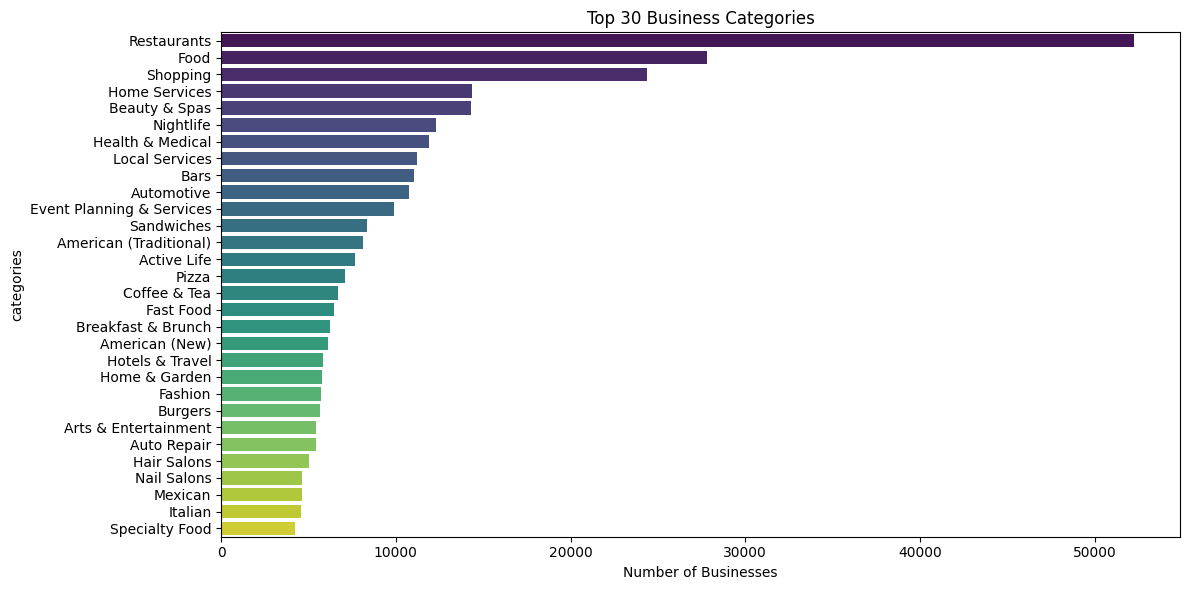

In [12]:
# Explosion des catégories (car format "Cat1, Cat2, ...")
categories_expanded = business_df.assign(categories=business_df['categories'].str.split(', ')).explode('categories')
top_categories = categories_expanded['categories'].value_counts().head(30)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title("Top 30 Business Categories")
plt.xlabel("Number of Businesses")
plt.tight_layout()
plt.savefig("../references/fig_categories.png", dpi=150)
plt.show()

## 3. Corrélation : Nombre d'avis vs Note Moyenne

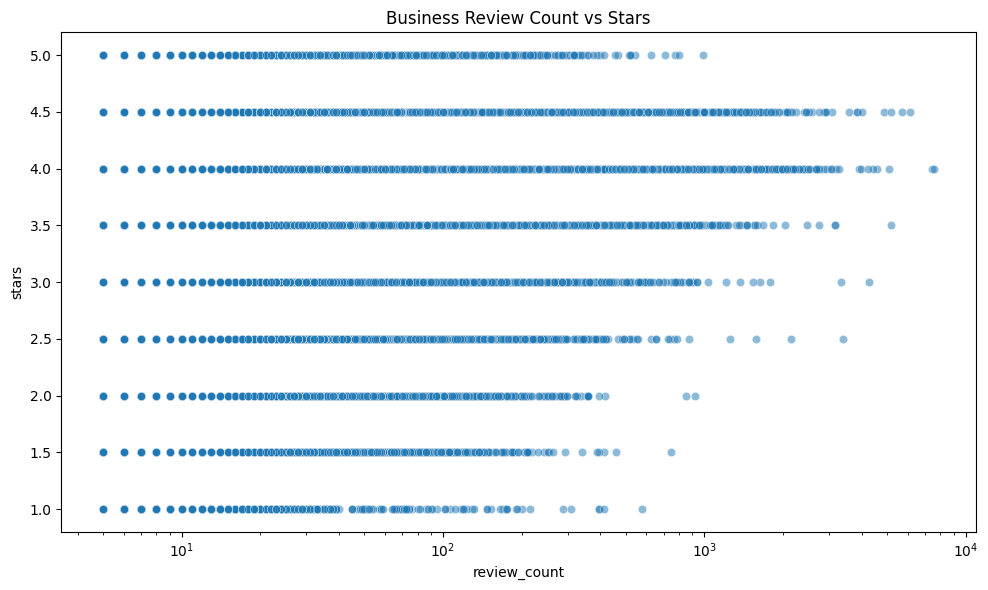

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=business_df, x="review_count", y="stars", alpha=0.5)
plt.title("Business Review Count vs Stars")
plt.xscale('log')
plt.tight_layout()
plt.savefig("../references/fig_reviews_vs_stars.png", dpi=150)
plt.show()

## 4. Analyse de la sévérité des "Big Reviewers"

Average rating given by reviewers:
is_big_reviewer
False    3.667107
True     3.821339
Name: avg_stars_given, dtype: float64


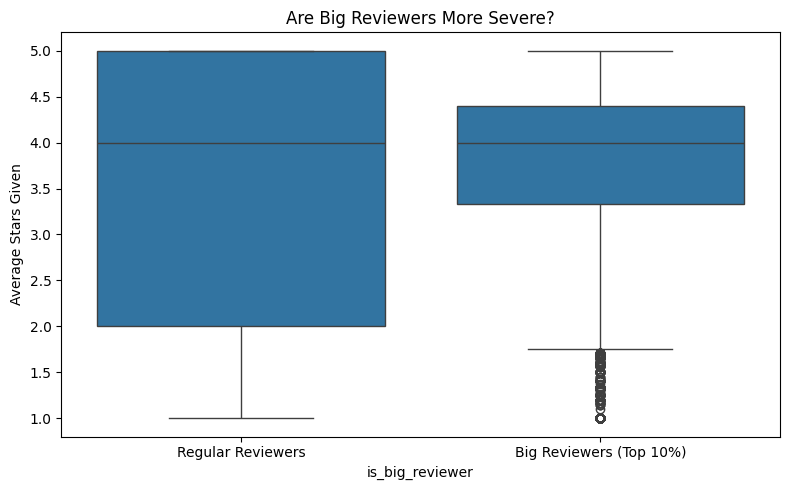

In [16]:
# Calculer la note moyenne donnée par chaque utilisateur
user_avg_rating = review_df.groupby('user_id')['stars'].agg(['mean', 'count']).reset_index()
user_avg_rating.columns = ['user_id', 'avg_stars_given', 'review_count']

# Big reviewers = top 10% par nombre d'avis
threshold = user_avg_rating['review_count'].quantile(0.90)
user_avg_rating['is_big_reviewer'] = user_avg_rating['review_count'] >= threshold

# Comparaison
comparison = user_avg_rating.groupby('is_big_reviewer')['avg_stars_given'].mean()
print("Average rating given by reviewers:")
print(comparison)

plt.figure(figsize=(8, 5))
sns.boxplot(data=user_avg_rating, x='is_big_reviewer', y='avg_stars_given')
plt.xticks([0, 1], ['Regular Reviewers', 'Big Reviewers (Top 10%)'])
plt.title("Are Big Reviewers More Severe?")
plt.ylabel("Average Stars Given")
plt.tight_layout()
plt.savefig("../references/fig_big_reviewers.png", dpi=150)
plt.show()

## 5. Longueur des reviews vs Note

Average review length by stars:
stars
1    713.219030
2    726.506557
3    668.441386
4    588.448649
5    462.938865
Name: text_length, dtype: float64


C:\Users\anas\AppData\Local\Temp\ipykernel_17196\1123743336.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=length_by_stars.index, y=length_by_stars.values, palette="coolwarm")


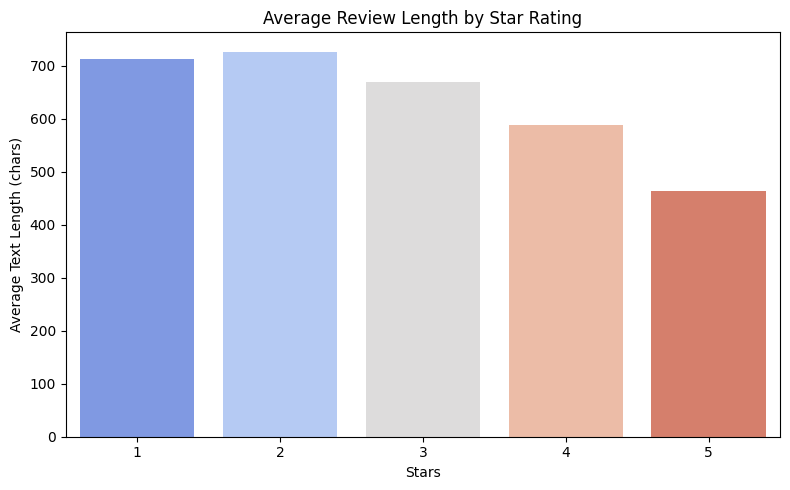

In [9]:
# Ajouter longueur du texte
review_df['text_length'] = review_df['text'].str.len()

# Moyenne par classe de note
length_by_stars = review_df.groupby('stars')['text_length'].mean()
print("Average review length by stars:")
print(length_by_stars)

plt.figure(figsize=(8, 5))
sns.barplot(x=length_by_stars.index, y=length_by_stars.values, palette="coolwarm")
plt.title("Average Review Length by Star Rating")
plt.xlabel("Stars")
plt.ylabel("Average Text Length (chars)")
plt.tight_layout()
plt.savefig("../references/fig_length_vs_stars.png", dpi=150)
plt.show()

## 6. Vocabulaire TF-IDF : Positifs vs Négatifs

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sous-échantillon pour la rapidité
sample_size = 10000
positive_reviews = review_df[review_df['stars'] >= 4]['text'].sample(min(sample_size, len(review_df[review_df['stars'] >= 4])), random_state=42)
negative_reviews = review_df[review_df['stars'] <= 2]['text'].sample(min(sample_size, len(review_df[review_df['stars'] <= 2])), random_state=42)

def get_top_tfidf_words(texts, n=10):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-n:][::-1]
    return [(feature_names[i], mean_tfidf[i]) for i in top_indices]

print("Top 10 TF-IDF words in POSITIVE reviews:")
top_positive = get_top_tfidf_words(positive_reviews)
for word, score in top_positive:
    print(f"  {word}: {score:.4f}")

print("\nTop 10 TF-IDF words in NEGATIVE reviews:")
top_negative = get_top_tfidf_words(negative_reviews)
for word, score in top_negative:
    print(f"  {word}: {score:.4f}")

Top 10 TF-IDF words in POSITIVE reviews:
  great: 0.0515
  food: 0.0438
  good: 0.0415
  place: 0.0400
  service: 0.0330
  time: 0.0273
  best: 0.0273
  amazing: 0.0243
  love: 0.0240
  like: 0.0236

Top 10 TF-IDF words in NEGATIVE reviews:
  food: 0.0437
  service: 0.0347
  place: 0.0345
  just: 0.0322
  time: 0.0305
  like: 0.0300
  good: 0.0278
  order: 0.0265
  don: 0.0242
  got: 0.0224


## 7. Préparation des labels pour la classification

In [ ]:
# Créer les labels de polarité
review_df['text_length'] = review_df['text'].str.len()

def get_polarity(stars):
    if stars > 3:
        return 'positive'
    elif stars < 3:
        return 'negative'
    else:
        return 'neutral'

review_df['polarity'] = review_df['stars'].apply(get_polarity)

print("Polarity distribution:")
print(review_df['polarity'].value_counts())

# Sauvegarder un dataset préparé pour la Phase B
prepared_df = review_df[['text', 'stars', 'polarity', 'text_length']].copy()
prepared_df.to_parquet("../Data/prepared_reviews.parquet", index=False)

print("\nSaved prepared dataset to ../Data/prepared_reviews.parquet")

Polarity distribution:
polarity
positive    670599
negative    230687
neutral      98714
Name: count, dtype: int64

Saved prepared dataset to ../Data/prepared_reviews.parquet
